<a href="https://colab.research.google.com/github/bfraiche/parkingdirty/blob/transfer_learning/parking_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import os
import random
import gc
import requests
import zipfile
import io
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

### ELT

In [0]:
nrows = 150
ncolumns = 150
channels = 3

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        if 'not' in image:
            y.append(1)
        else:
            y.append(0)
    
    return X, y

In [0]:
pkngdrty 	= 'http://parkingdirty.com/BlockedBikeLaneTrainingSingleCam.zip'

rPd = requests.get(pkngdrty)
zPd = zipfile.ZipFile(io.BytesIO(rPd.content))
zPd.extractall()

In [0]:
# separate raw image files into training and test sets
n_blocked = len([name for name in os.listdir('blocked')])
n_unblocked = len([name for name in os.listdir('notblocked')])

# make the training set have equal images for each class
if(n_blocked >= n_unblocked):
  n_train = round(n_unblocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train
else:
  n_train = round(n_blocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train

train_blocked = ['blocked/{}'.format(i) for i in os.listdir('blocked')]
train_notblocked = ['notblocked/{}'.format(i) for i in os.listdir('notblocked')]

random.shuffle(train_blocked)
random.shuffle(train_notblocked)

train_imgs = train_blocked[:n_train] + train_notblocked[:n_train]

test_imgs = train_blocked[n_test_b:] + train_notblocked[n_test_ub:]

# format images for model
X, y = read_and_process_image(train_imgs)

In [0]:
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [0]:
# # clear memory
# del X, y, train_imgs, train_blocked, train_notblocked, n_train, n_test_ub, n_test_b, n_blocked, n_unblocked, rPd, zPd
# gc.collect()

### Define Model

In [9]:
from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

219062272/219055592 [==============================] - 16s 0us/step


In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
conv_base.trainable = False

In [0]:
#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-4), metrics=['acc'])

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

### Train Model

In [14]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100, 
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=100)

Epoch 1/20
100/100 [==============================] - 60s 597ms/step - loss: 0.7932 - acc: 0.5419 - val_loss: 1.5244 - val_acc: 0.5383
Epoch 2/20
100/100 [==============================] - 42s 422ms/step - loss: 0.6689 - acc: 0.6016 - val_loss: 1.0188 - val_acc: 0.5927
Epoch 3/20
100/100 [==============================] - 42s 422ms/step - loss: 0.6655 - acc: 0.6078 - val_loss: 0.7002 - val_acc: 0.5841
Epoch 4/20
100/100 [==============================] - 43s 426ms/step - loss: 0.6409 - acc: 0.6369 - val_loss: 0.9194 - val_acc: 0.5770
Epoch 5/20
100/100 [==============================] - 42s 421ms/step - loss: 0.6315 - acc: 0.6537 - val_loss: 0.7530 - val_acc: 0.6142
Epoch 6/20
100/100 [==============================] - 42s 422ms/step - loss: 0.6242 - acc: 0.6609 - val_loss: 0.9343 - val_acc: 0.5773
Epoch 7/20
100/100 [==============================] - 42s 423ms/step - loss: 0.6304 - acc: 0.6441 - val_loss: 0.7611 - val_acc: 0.6226
Epoch 8/20
100/100 [==============================] - 4

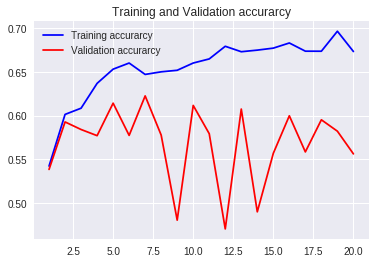

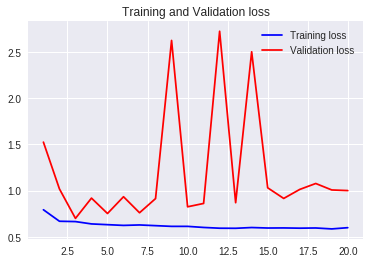

In [15]:
# plot the train and val curve
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### Evaluate Model

Predict the first 10 images of the test set

In [0]:
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

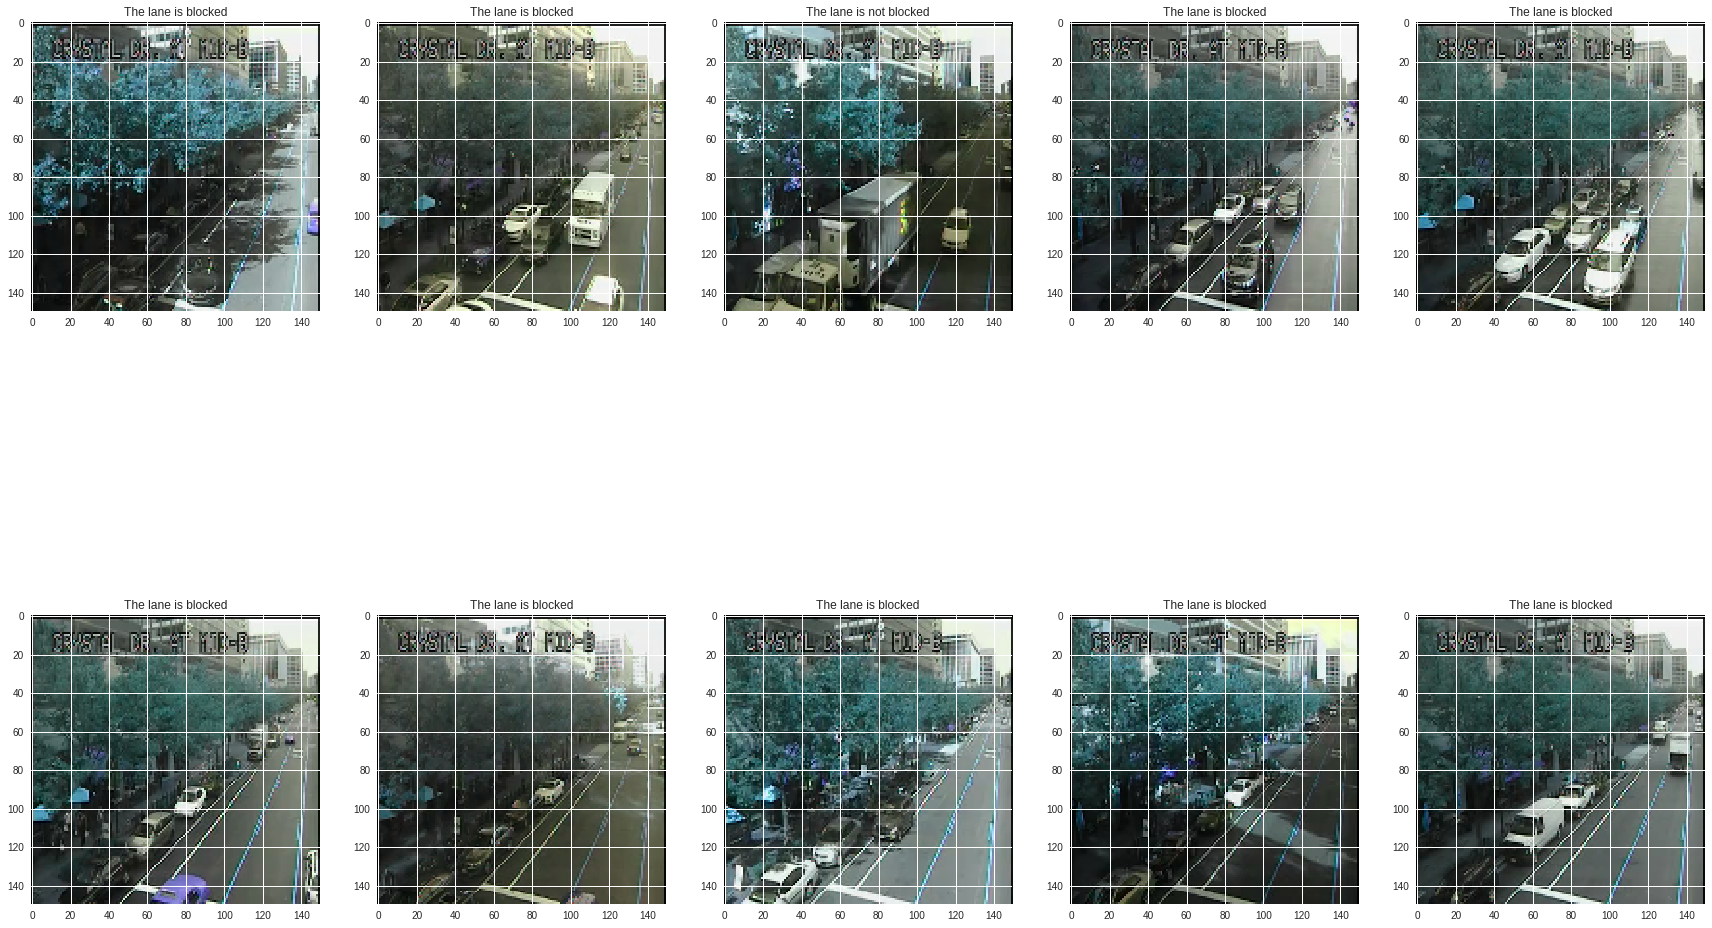

In [17]:
i = 0
text_labels = []
columns = 5
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('not blocked')
    else:
        text_labels.append('blocked')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('The lane is ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()